In [1]:
# An example plotting script for DCMIP 2025 gravity wave break test case

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import matplotlib
import matplotlib.colors as colors
import metpy.calc as mpc
import xarray as xr
from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# Parameters from the simulation:
small_earth_fact = 20.0
# mountain params
mtn_height = 4000
center_lon = np.deg2rad(72)
mtn_center_lat = np.deg2rad(45)
width_lon = np.deg2rad(7)
width_lat = np.deg2rad(40)
param_lon = width_lon / 2.0 * 1.0/(np.sqrt(-np.log(0.1)))
param_lat = width_lat / 2.0 * 1.0/(np.power(-np.log(0.1), 6))

In [16]:
def mountain_shape(lons):
    # height = np.zeros(np.shape(lons))
    height = mtn_height * np.exp(-np.square(lons-center_lon)/param_lon - np.square(np.deg2rad(lat_slice)-mtn_center_lat)/param_lat)
    return height

In [5]:
# Information about the paths
model = 'SE' # 'SE' or 'FV3' or 'MPAS'
vert = 'hydrostatic' # or 'nonhydrostatic'

# Name of your CAM clone:
CAM_dirname = 'CAM_6_4_060_06032025'

# Edit this to your own case name
case = 'dcmip2025_horiz_mount_flow_se_ne30'
# case = 'dcmip2025_horiz_mount_flow_mpasa120'

# Modify the following according to your naming convention
nc_file = case + '.cam.h0i.0001-01-01-00000.nc'
# nc_file = case + '.cam.h0i.0001-01-01-00000.regrid.1x1.nc'

# Define the base root to the data, add your username
username = 'timand'
run_base = f'/glade/derecho/scratch/{username}/'
output_base = f'/glade/u/home/{username}/'

In [6]:
# Automatically set some paths
run_path = run_base + case + '/run/' + nc_file
# output_dir = f'{CAM_dirname}/plotting/'
# output_file = output_base + output_dir

In [7]:
ds = xr.open_dataset(run_path).drop_dims({'ilev', 'trop_pref', 'trop_prefi'})
nc = Dataset(run_path)

In [40]:
# specify desired plotting variables
field = 'div' # modify this! options = 'U', 'V', 'W', 'T', 'div', 'vor'
t_idxs = [5, 10, 15, 20] # Each index is 0.25 small Earth hours, can modify, up to 20
lat_slice = 45
pt_cont = True # whether or not to plot potential temperature contours

In [41]:
time_stamps = ds['time']
lats = ds['lat']
lons = ds['lon']
levs = ds['lev']
ncts = nc['time'][:]

print(f'There are {len(time_stamps)} time samples')
print(f'{len(lats)} latitiude points, {len(lons)} longitude points')

There are 41 time samples
257 latitiude points, 512 longitude points


In [42]:
# Crop to the subdomain of interest

lon_crop_left = 50.
lon_crop_right = 120.
lon_ticks = np.linspace(60, 110, 6) # Plotting ticks

if model != "MPAS":
    height_bot = 0
    height_top = 40000
    height_levs = np.linspace(height_bot, height_top, 51)

lon_inds = np.where((lons > lon_crop_left) & (lons < lon_crop_right))[0]

print(f'{len(lon_inds)} lon vals will be plotted')

lon_slice = lons[lon_inds] 
heights = mountain_shape(np.deg2rad(lon_slice))

99 lon vals will be plotted


In [43]:
if model == "MPAS":
    # already in height coordinates, no vertical interp needed
    vals = ds[field].interp(lat=lat_slice, method='linear').isel(time=t_idxs, lon=lon_inds)
else:
    # interp from pressure to height coordiantes
    if field == 'div':
        z3 = ds['Z3'].isel(time=t_idxs).interp(lat=lat_slice).isel(lon=lon_inds)
        div = mpc.divergence(ds['U'].isel(time=t_idxs), ds['V'].isel(time=t_idxs)).interp(lat=lat_slice).isel(lon=lon_inds).to_dataset(name='div').assign(Z3=z3)
        vals = small_earth_fact*z_interp_divvor(div, t_idxs, height_levs, lon_inds)
    elif field == 'vor':
        z3 = ds['Z3'].isel(time=t_idxs).interp(lat=lat_slice).isel(lon=lon_inds)
        vor = mpc.vorticity(ds['U'].isel(time=t_idxs), ds['V'].isel(time=t_idxs)).interp(lat=lat_slice).isel(lon=lon_inds).to_dataset(name='vor').assign(Z3=z3)
        vals = small_earth_fact*z_interp_divvor(vor, t_idxs, height_levs, lon_inds)
    else:
        vals = z_interp_xr(ds[[field, 'Z3']].interp(lat=lat_slice, method='linear'), t_idxs, height_levs, lon_inds)

In [44]:
if pt_cont: # potential temperature contours
    if model == "MPAS":
        ds = ds
    else:
        z3 = ds['Z3'].isel(time=t_idxs).interp(lat=lat_slice, method='linear').isel(lon=lon_inds)
        hyam = ds['hyam']
        hybm = ds['hybm']
        pressure = hyam*1e5 + hybm*ds['PS'].isel(time=t_idxs, lon=lon_inds).interp(lat=lat_slice, method='linear')
        mod_pres = np.power(1e5 / pressure, 0.286)
        pot_temp = ds['T'].isel(time=t_idxs, lon=lon_inds).interp(lat=lat_slice, method='linear') * mod_pres
        pt_interp = z_interp_divvor(pot_temp.to_dataset(name="potential temperature").assign(Z3=z3), t_idxs, height_levs, lon_inds)

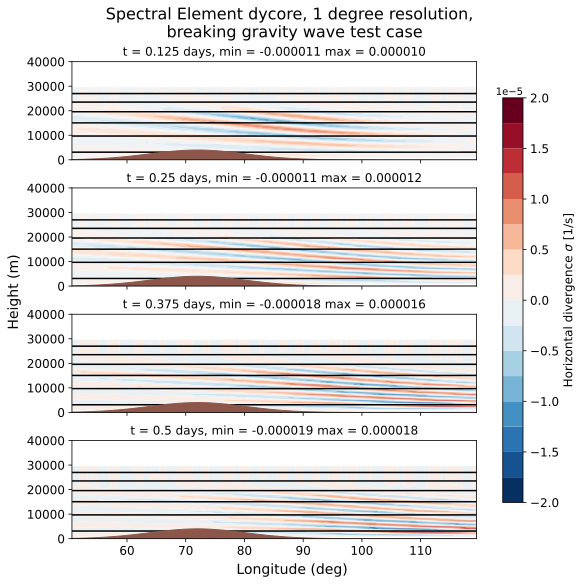

In [45]:
# make the plot
fig, axes = plt.subplots(len(t_idxs),1, figsize=(8.0,8.0*len(t_idxs)/4.0), sharex=True, layout='constrained')

title_size=16
label_size=14
small_size=12
round_dig = 2

fix_minmax = False

# Feel free to add additional fields
if field == 'T':
    title = 'Temperature'
    cb_label = '$T$ [K]'
    min = -2
    max = 5
elif field == 'U':
    title = 'Zonal velocity'
    cb_label = '$u$ [m/s]'
    min = -1.5
    max = 0.6
elif field == 'V':
    title = "Meridional velocity"
    cb_label = '$v$ [m/s]'
    min = -9
    max = 9
elif field == 'div':
    title = "Horizontal divergence"
    cb_label = '$\sigma$ [1/s]'
    round_dig = 6

# for the color map
valmin = np.nanmin(vals)
valmax = np.nanmax(vals)
if ((-1e-10 > valmin) and (1e-10 < valmax)):
    if fix_minmax:
        norm = MidpointNormalize(midpoint = 0, vmin = min, vmax = max)
    else:
        norm = MidpointNormalize(midpoint = 0, vmin = valmin, vmax = valmax)
    cmap_choice = 'RdBu_r'
elif (valmin < 1e-10):
    cmap_choice = "Blues"
    if (fix_minmax):
        norm = colors.Normalize(vmin=min, vmax=max)
    else:
        norm = colors.Normalize(vmin=0, vmax=valmax)       
else:
    if (fix_minmax):
        norm = colors.Normalize(vmin=min, vmax=max)
    else:
        norm = colors.Normalize(vmin=valmin, vmax=valmax)
    cmap_choice = 'RdYlBu_r'

if fix_minmax:
    levels = 17
    levels = np.mgrid[min:max:levels*1j]
else:
    levels = 15

for ind, ax in enumerate(np.ravel(axes)):
    if fix_minmax:
        plot = ax.contourf(lon_slice, height_levs, vals[ind], levels=levels, cmap=cmap_choice, norm=norm, extend='both')
    else:
        plot = ax.contourf(lon_slice, height_levs, vals[ind], levels=levels, cmap=cmap_choice, norm=norm)

    if pt_cont:
        ax.contour(lon_slice, height_levs, pt_interp[ind], colors='black')
    ax.tick_params(axis='both', labelsize=small_size)
    ax.set_title(f't = {ncts[t_idxs[ind]]} days, min = ' + '%.*f' % (round_dig, np.nanmin(vals[ind])) + ' max = ' + '%.*f' % (round_dig, np.nanmax(vals[ind])))
    ax.fill_between(lon_slice, heights, color='tab:brown', zorder=2)

cb = plt.colorbar(plot, ax=axes, fraction=0.05*len(t_idxs)/4.0)
cb.set_label(label=title + " " + cb_label, size=small_size)
cb.ax.tick_params(labelsize=small_size)

fig.supylabel('Height (m)', size=label_size)
fig.supxlabel('Longitude (deg)', size=label_size)

fig.suptitle('Spectral Element dycore, 1 degree resolution, \n breaking gravity wave test case', size=title_size)

plt.show()